In [124]:
import numpy as np
from sklearn import preprocessing
import sys
import xlrd
import random
import pandas as pd
import csv
import os
from keras import models
from keras import layers
from keras.models import Sequential
from keras.layers import Dense,Dropout
import keras_metrics as km
from keras.utils import to_categorical
import keras
from sklearn.preprocessing import LabelEncoder,LabelBinarizer

In [125]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [126]:
#圖表函數
import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

# **<font color = red>資料分割</font>**

In [127]:
trainingData = pd.read_csv("data\\adultTrain.csv")
trainingData[:3]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50k
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50k
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50k


In [128]:
testingData = pd.read_csv("data\\adultTest.csv")
testingData[:3]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50k
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50k
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50k


# **<font color = red>資料前置處理_1.刪除空直_2.將類別數值化_3.切割輸入輸出</font>**

In [129]:
trainingData=trainingData.dropna()
testingData=testingData.dropna()

In [130]:
labelencoder = LabelEncoder()

trainingData['workclass'] = labelencoder.fit_transform(trainingData['workclass'])
trainingData['education'] = labelencoder.fit_transform(trainingData['education'])
trainingData['marital-status'] = labelencoder.fit_transform(trainingData['marital-status'])
trainingData['occupation'] = labelencoder.fit_transform(trainingData['occupation'])
trainingData['relationship'] = labelencoder.fit_transform(trainingData['relationship'])
trainingData['race'] = labelencoder.fit_transform(trainingData['race'])
trainingData['sex'] = labelencoder.fit_transform(trainingData['sex'])
trainingData['native-country'] = labelencoder.fit_transform(trainingData['native-country'])
trainingData['income'] = labelencoder.fit_transform(trainingData['income'])

testingData['workclass'] = labelencoder.fit_transform(testingData['workclass'])
testingData['education'] = labelencoder.fit_transform(testingData['education'])
testingData['marital-status'] = labelencoder.fit_transform(testingData['marital-status'])
testingData['occupation'] = labelencoder.fit_transform(testingData['occupation'])
testingData['relationship'] = labelencoder.fit_transform(testingData['relationship'])
testingData['race'] = labelencoder.fit_transform(testingData['race'])
testingData['sex'] = labelencoder.fit_transform(testingData['sex'])
testingData['native-country'] = labelencoder.fit_transform(testingData['native-country'])
testingData['income'] = labelencoder.fit_transform(testingData['income'])

In [131]:
#分割成輸入及輸出
cols = ['education']
train_Label = trainingData[cols]
train_Features = trainingData.drop(cols,axis=1)
test_Label = testingData[cols]
test_Features = testingData.drop(cols,axis=1)

In [132]:
#進行資料正規化
min_max_scaler = preprocessing.MinMaxScaler()
train_Features = min_max_scaler.fit_transform(trainingData)
train_Label = to_categorical(trainingData['education'])
test_Features = min_max_scaler.fit_transform(testingData)
test_Label = to_categorical(testingData['education'])

# **<font color = red>建構model</font>**

In [134]:
#產生網路層
model = Sequential()

model.add(Dense(units=64,
                kernel_initializer='uniform',
                activation='relu',
                input_shape=(train_Features.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(units=16,activation='relu'))
model.add(Dropout(0.2))
# model.add(Dense(units=16,
#                 kernel_initializer='uniform',
#                 activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(train_Label.shape[1],
                kernel_initializer='uniform',
                activation='softmax'))

In [135]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',f1_m,precision_m, recall_m])

In [136]:
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 64)                1024      
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 16)                1040      
_________________________________________________________________
dropout_13 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 16)                272       
Total params: 2,336
Trainable params: 2,336
Non-trainable params: 0
_________________________________________________________________
None


In [137]:
#開始訓練
train_history = model.fit(x=train_Features,
                          y=train_Label,
                          validation_split=0.1,
                          epochs=30,
                          batch_size=512,
                          verbose=0)

In [138]:
loss, accuracy, f1_score, precision, recall = model.evaluate(test_Features, test_Label, verbose=0)
print(loss, accuracy, f1_score, precision, recall)

0.09378256648778915 0.9874086380004883 0.9882731437683105 0.9998732805252075 0.9772838950157166


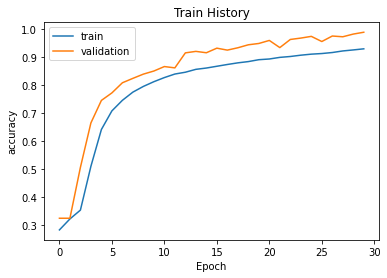

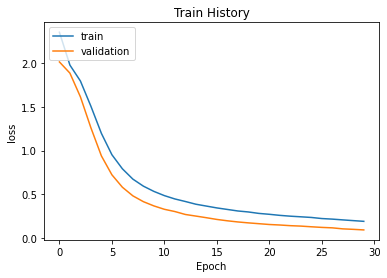

In [139]:
show_train_history(train_history,'accuracy','val_accuracy')
show_train_history(train_history,'loss','val_loss')